### Setting up cellpose on GPU

In [ ]:
# !nvcc --version
# !nvidia-smi

Install cellpose, then uninstall the CPU version, then install the GPU version

(make sure cu101 is the right CUDA version, e.g. mine is 10.1 so cu101 works, 10.0 would be cu100)

In [ ]:
# !pip install cellpose
# !pip uninstall mxnet-mkl -y
# !pip install mxnet-cu101

In [ ]:
# import mxnet as mx
# from cellpose import utils
# from cellpose import models

# use_GPU = utils.use_gpu()
# print("GPU activated? %d" % use_GPU)

### Analysis using cellpose

In [ ]:
# sys.path.append("/content/drive/My Drive/Learning Python_copy/Code")
# path_to_image_folder = "/content/drive/My Drive/Colab Notebooks/Current_Imaging_Analysis_Colab/Laconic_III_esgts_Young_vs_Old_E1F1/BacSub50/Analysis/Posterior/Trying_cellpose"
# os.chdir(path_to_image_folder)

In [ ]:
# C0_imgs = create_img_dict_from_folder(load_pattern="./C0/*.tif")
# C1_imgs = create_img_dict_from_folder(load_pattern="./C1/*.tif")

In [ ]:
# model = models.Cellpose(gpu=use_GPU, model_type="cyto",)

In [ ]:
# masks, flows, styles, diams = model.eval(
#     list(C1_imgs.values()),
#     diameter=35,
#     channels=[[0, 0]] * len(C1_imgs.keys()),
#     cellprob_threshold=2,
# )

In [ ]:
# from cellpose import plot

# nimg = len(list(C1_imgs.values()))
# for idx in range(nimg):
#     maski = masks[idx]
#     flowi = flows[idx][0]

#     fig = plt.figure(figsize=(18, 12))
#     plot.show_segmentation(fig, list(C1_imgs.values())[idx], maski, flowi, [[0]])
#     plt.tight_layout()
#     plt.show()

In [ ]:
# C1_imgs_lab = dict(zip(list(C1_imgs.keys()), masks))

In [ ]:
# save_dict_binary_masks(C1_imgs_lab, "C1_label_imgs", method_img_type=img_as_ubyte)

### Per cell analysis

In [3]:
import numpy as np
import time, os, sys
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
import napari
import glob
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Otto's python modules
from cell_counting_analysis import (
    create_img_dict_from_folder,
    save_dict_binary_masks,
    measure_region_props_to_tidy_df,
    create_labelled_img_dict_from_folder,
    num_div_denom_measure_region_props_to_tidy_df,
)
import analysing_imaging_data as aid
import custom_plotting as cp

In [4]:
C0_imgs = create_img_dict_from_folder(load_pattern="./C0/*.tif")
C1_imgs = create_img_dict_from_folder(load_pattern="./C1/*.tif")


# generated using cellpose cytoplasm model
C1_imgs_lab = create_labelled_img_dict_from_folder(load_pattern="C1_label_imgs/*.tiff")

In [6]:
%gui qt5

In [8]:
import napari

view = napari.Viewer()

In [9]:
view.layers.select_all()
view.layers.remove_selected()
key = "o1g1"
view.add_image(C0_imgs.get(key), name=key + "_C0", colormap="blue")
view.add_image(C1_imgs.get(key), name=key + "_C1", colormap="yellow")
view.add_labels(C1_imgs_lab[key], name=key + "_label")

<Labels layer 'o1g1_label' at 0x7ffe6443b350>

In [202]:
df = num_div_denom_measure_region_props_to_tidy_df(
    num_img_dict=C0_imgs,
    denom_img_dict=C1_imgs,
    label_imgs=C1_imgs_lab,
    sample_id_categories=["a1", "o1"],
)

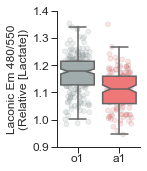

In [201]:
mypal = cp.define_pallette_tidy(df["sample_id"])
cp.tidy_create_strip_box_plot(
    x="sample_id",
    y="mean_intensity_num_div_denom",
    palette=mypal,
    x_figSize=cp.determine_fig_width_from_palette(mypal),
    data=df.query("mean_intensity_num_div_denom < 1.4"),
    y_axis_start=0.9,
    y_axis_limit=1.4,
    y_label=cp.identify_y_axis_label(aid.exp_analysis_name()),
)

### Performing statistical tests on per cell data

In [12]:
from scipy import stats
import scikit_posthocs as sp
from statsmodels import formula
from statsmodels import api
import custom_stats

In [22]:
custom_stats.kruskal_scipy_stats_tidy_df_wrapper(
    tidy_df=df, indep_var="sample_id", dep_var="mean_intensity_num_div_denom"
)

KruskalResult(statistic=66.65101926680472, pvalue=3.2408863581511514e-16)

In [20]:
sp.posthoc_dunn(
    df,
    val_col="mean_intensity_num_div_denom",
    group_col="sample_id",
    p_adjust="bonferroni",
)

,a1,o1
a1,-1.000000e+00,3.240886e-16
o1,3.240886e-16,-1.000000e+00


### Per gut analysis

In [204]:
foo = aid.grouped_tidy_data_summary_stats(df, categories=df["sample_id"].unique())

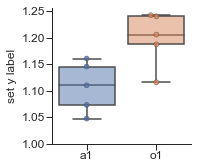

In [205]:
cp.tidy_create_swarm_box_plot(
    x="sample_id",
    y="mean_intensity_num_div_denom",
    data=foo.query('summary_stat == "mean"'),
    y_axis_start=1,
)

### Perform statistical tests using per gut data

In [220]:
lm = (
    formula.api.ols(
        formula="mean_intensity_num_div_denom ~ C(sample_id)",
        data=foo.query('summary_stat == "mean"'),
    )
    .fit()
)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     mean_intensity_num_div_denom   R-squared:                       0.511
Model:                                      OLS   Adj. R-squared:                  0.450
Method:                           Least Squares   F-statistic:                     8.370
Date:                          Wed, 17 Jun 2020   Prob (F-statistic):             0.0201
Time:                                  14:29:15   Log-Likelihood:                 16.961
No. Observations:                            10   AIC:                            -29.92
Df Residuals:                                 8   BIC:                            -29.32
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1074      0.022     49.907      0.000       1.056       1.159
C(sample_id)[T.o1]     0.0908      0.031      2.893      0.020       0.018       0.163
==============================================================================
Omnibus:                        1.139   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.867
Skew:                          -0.516   Prob(JB):                        0.648
Kurtosis:                       1.992   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [227]:
stats.ttest_ind(
    foo.query('summary_stat == "mean" & sample_id == "a1"')['mean_intensity_num_div_denom'].values,
    foo.query('summary_stat == "mean" & sample_id == "o1"')['mean_intensity_num_div_denom'].values,
)

Ttest_indResult(statistic=-2.8930373885204235, pvalue=0.02010525313059703)